<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Final_project_initial_dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs, imports, and Google Drive mounting

### Installs

In [0]:
#!pip install --no-cache-dir -I pillow # This line must be FIRST
!pip3 install torch torchvision tqdm
!pip3 install pillow==4.1.1
#!pip install PyPDF2

#!apt-get install libmagickwand-dev
#!pip install wand

### The very hacky way I figured out to edit the ImageMagick policy.xml file

In [0]:
p = """
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE policymap [
<!ELEMENT policymap (policy)+>
<!ELEMENT policy (#PCDATA)>
<!ATTLIST policy domain (delegate|coder|filter|path|resource) #IMPLIED>
<!ATTLIST policy name CDATA #IMPLIED>
<!ATTLIST policy rights CDATA #IMPLIED>
<!ATTLIST policy pattern CDATA #IMPLIED>
<!ATTLIST policy value CDATA #IMPLIED>
]>
<!--
  Configure ImageMagick policies.

  Domains include system, delegate, coder, filter, path, or resource.

  Rights include none, read, write, and execute.  Use | to combine them,
  for example: "read | write" to permit read from, or write to, a path.

  Use a glob expression as a pattern.

  Suppose we do not want users to process MPEG video images:

    <policy domain="delegate" rights="none" pattern="mpeg:decode" />

  Here we do not want users reading images from HTTP:

    <policy domain="coder" rights="none" pattern="HTTP" />

  Lets prevent users from executing any image filters:

    <policy domain="filter" rights="none" pattern="*" />

  The /repository file system is restricted to read only.  We use a glob
  expression to match all paths that start with /repository:
  
    <policy domain="path" rights="read" pattern="/repository/*" />

  Let's prevent possible exploits by removing the right to use indirect reads.

    <policy domain="path" rights="none" pattern="@*" />

  Any large image is cached to disk rather than memory:

    <policy domain="resource" name="area" value="1GB"/>

  Define arguments for the memory, map, area, width, height, and disk resources
  with SI prefixes (.e.g 100MB).  In addition, resource policies are maximums
  for each instance of ImageMagick (e.g. policy memory limit 1GB, -limit 2GB
  exceeds policy maximum so memory limit is 1GB).
-->
<policymap>
  <policy domain="resource" name="memory" value="4GB" />
  <!-- policy domain="resource" name="map" value="512MiB"-->
  <!-- policy domain="resource" name="width" value="16KP"-->
  <!-- policy domain="resource" name="height" value="16KP"-->
  <!-- policy domain="resource" name="area" value="128MB"-->
  <policy domain="resource" name="disk" value="3GB">
  <policy domain="delegate" rights="none" pattern="URL" />
  <policy domain="delegate" rights="none" pattern="HTTPS" />
  <!-- in order to avoid to get image with password text -->
  <!-- policy domain="path" rights="none" pattern="@*" -->
  <policy domain="cache" name="shared-secret" value="passphrase" stealth="true"/>
  <!-- disable ghostscript format types -->
  <policy domain="coder" rights="read" pattern="PS" />
  <policy domain="coder" rights="read" pattern="EPI" />
  <policy domain="coder" rights="read|write" pattern="PDF" />
  <policy domain="coder" rights="read|write" pattern="PNG" />
  <policy domain="coder" rights="read|write" pattern="LABEL" />
  <policy domain="coder" rights="read" pattern="XPS" />
  <policy domain="coder" rights="read|write" pattern="EPS" />
</policymap>
"""
c = """text_file = open("/etc/ImageMagick-6/policy.xml","w+");text_file.write(p);text_file.close()"""
exec(c)

FileNotFoundError: ignored

### Imports

In [0]:
import os
import csv
import copy
import glob
from collections import defaultdict

import seaborn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, BatchSampler
from torchvision import models, transforms, utils, datasets

# PDF conversion and image handling stuff
#import PyPDF2
#import io
#from wand.image import Image as WandImage

import PIL.Image
def register_extension(id, extension):
    PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

### Drive mounting

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# One-time dataset construction stuff

In [0]:
partial_base = '/content/gdrive/My Drive/CS 501R/Final Project/'
base_filename = partial_base + 'Old Exams/'
subfolder_names = glob.glob(base_filename + '*')

names_to_use = {"W18 Exam 1":"W18_Exam1", "M112 F17 Final Exam":"F17_Final",
                "M112 W18 Final Exam":"W18_Final", "Math112Exam2":"F18_Exam2",
                "M112_Fall_2018_Midterm_1":"F18_Exam1", "F17 Exam2":"F17_Exam2",
                "Exam 2 Winter 2018":"W18_Exam2"}

easy_names = dict()
associated_files = defaultdict(set)

for folder_name in subfolder_names:
    stripped_name = folder_name.replace(base_filename,"").strip()
    if stripped_name in names_to_use:
        easy_names[names_to_use[stripped_name]] = folder_name

In [0]:
# For each exam group we care about
for folder in easy_names:
    
    # Fetch all the files we know are graded within it
    for file in glob.glob(easy_names[folder]+'/**/*.pdf', recursive=True):
        stub = file.replace(base_filename,"").lower()
        if "ungraded" not in stub and "graded" in stub:
            
            # Only keep files larger than 5MB
            if os.stat(file).st_size > 5*1e6:
                associated_files[folder].add(file)

# Look at how many we have
total_files = 0                
for folder in easy_names:
    total_files += len(associated_files[folder])
    print(folder+": "+str(len(associated_files[folder]))+" graded files") 
print(total_files, "files in total")
 
# Write to .csv file to go check metadata
with open(partial_base + 'metadata.csv', 'w') as f:
    
    writer = csv.writer(f)
    writer.writerow(["Full filename", "Source folder", "Stub filename", 
                     "Question #", "Question value"])
    
    for folder in easy_names:
        for file in associated_files[folder]:
            row = [file, folder, file.replace(base_filename,""), 0, 0]
            writer.writerow(row)

## Read in the (hard-coded) question # + pts possible metadata

In [0]:
class GradedFile:
    
    def __init__(self, filename, source, num, value):
        
        self.shortname = filename.replace(base_filename, "")
        self.source = source
        self.filename = filename
        self.question_number = num # Int with question #
        self.question_value = value # Int with how many pts it's out of

# Read in metadata from spreadsheet
all_files = dict()
parent_folders = defaultdict(set)
with open(partial_base + 'metadata_finished.csv', 'r') as f:
    
    reader = csv.reader(f)
    
    for (filename, source, stub, num, value, ignore, reason) in reader: 
        if ignore == '0':
            all_files[filename] = GradedFile(filename, source, num, value)
            parent_folders[source].add(filename)
            
# Look at how many we have
total_files = 0                
for folder in easy_names:
    total_files += len(parent_folders[folder])
    print(folder+": "+str(len(parent_folders[folder]))+" graded files") 
print(total_files, "files in total")

W18 Exam 1/W18 Exam 1 Graded/Processed 2 27 18/Hendrickson_graded.pdf
	Question #21
	6 pts
	17.7 MB 

F17_Exam2: 13 graded files
W18_Exam1: 10 graded files
W18_Exam2: 17 graded files
W18_Final: 20 graded files
F18_Exam1: 16 graded files
F17_Final: 12 graded files
F18_Exam2: 21 graded files
109 files in total


## Convert from PDFs to individual .png pages

In [0]:
def short_name(filename):
    splits = filename.replace(base_filename,"").rsplit('/')
    return names_to_use[splits[0]] + '/' + splits[-1].replace(".pdf","")

def page_to_png(pdf_reader, i, resolution=150):
    
    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(pdf_reader.getPage(i))

    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)

    return WandImage(file=pdf_bytes, resolution=150)

m = len(all_files)
j = 0

loop = tqdm(total=m, position=0, leave=True)
for filename, gradefile in all_files.items():
    
    filename_base = partial_base + 'Graded Pages/' + short_name(filename)
    pdf_reader = PyPDF2.PdfFileReader(open(filename, 'rb'))
    
    splits = filename.replace(base_filename,"").rsplit('/')
    n = pdf_reader.numPages
    
    
    s = "/"+str(n)+" (File "+str(j)+"/"+str(m)+")"
    
    existing_files = glob.glob(filename_base + "_page*.png")
    
    if len(existing_files) < n:
        
        for i in range(n):

            loop.set_description(splits[-1] +": converting pg "+str(i)+s)
            filename = filename_base + "_page" + str(i) + ".png"
            
            if filename not in existing_files:
            
                img = page_to_png(pdf_reader, i)
                with img.convert('png') as converted:
                    converted.save(filename=filename)
            
    else:
        loop.set_description(short_name(filename) + " already converted")
        
    loop.update(1)
    j += 1

  0%|          | 0/109 [00:00<?, ?it/s]PdfReadWarning: Xref table not zero-indexed. ID numbers for objects will be corrected. [pdf.py:1736]
Christensen_graded.pdf: converting pg 232/233 (File 108/109): 100%|██████████| 109/109 [32:11<00:00, 120.95s/it]

## Look at how many we had loaded

In [0]:
def count_loaded():
    for folder in easy_names:
        base_name = partial_base + "Graded Pages/" + folder
        print(len(glob.glob(base_name + "/*.png")))

    print("Total:", len(glob.glob(partial_base + "Graded Pages/**/*.png", 
                                  recursive=True)))

In [0]:
count_loaded()

7337
2437
3846
5303
7924
5352
4567
Total: 36766


In [0]:
count_loaded()

7337
2204
404
5303
7924
5352
4567
Total: 33091


In [0]:
count_loaded()

5798
2204
0
5303
7924
5352
4567
Total: 31148


In [0]:
count_loaded()

4659
2204
0
5303
7924
5352
4567
Total: 30009


In [0]:
for folder in easy_names:
    base_name = partial_base + "Graded Pages/" + folder
    print(len(glob.glob(base_name + "/*.png")))
    
print("Total:", len(glob.glob(partial_base + "Graded Pages/**/*.png", 
                              recursive=True)))

3803
2204
0
5303
7924
5352
4567
Total: 29153


# Debug/play with score predictor training stuff

### Hard-coding

In [0]:
PARTIAL_BASE = '/content/gdrive/My Drive/CS 501R/Final Project/'

NEW_NAMES = {"W18 Exam 1":"W18_Exam1", "M112 F17 Final Exam":"F17_Final",
                "M112 W18 Final Exam":"W18_Final", "Math112Exam2":"F18_Exam2",
                "M112_Fall_2018_Midterm_1":"F18_Exam1", "F17 Exam2":"F17_Exam2",
                "Exam 2 Winter 2018":"W18_Exam2"}

def display_img(img):
    fig = plt.figure(figsize=(9,12))
    img = img.permute(1,2,0)
    plt.imshow(img.detach())
    plt.show()
    
def new_filename(original_filename):
    s = original_filename.replace(base_filename('Old Exams/'),"").rsplit('/')
    return "Graded Pages/" + NEW_NAMES[s[0]] + "/" + s[-1].replace(".pdf","")

def base_filename(extension=""):
    return '/content/gdrive/My Drive/CS 501R/Final Project/' + extension

def short_filename(filename):
    return filename.replace(base_filename(), "")

def score_labeled_from_stub(fname):
    stub = 'Score Labeling/Score Labeled/' 
    return stub + fname.replace('Graded Pages/','').replace('/','_')

def plot_zip(ax, validations, losses, ylabel, num_epochs=1):
    
    a, b = zip(*validations)
    ax.plot(losses, label='train')
    ax.plot(a, b, label='val')
    ax.set_xlabel('Batch number')
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel + " over {} epochs".format(num_epochs))
    ax.legend()  
    
def loop_s(epoch, num_epochs, s_loss, s_acc, m_loss, m_acc, validation):
    
    if validation:
        s = "Validation {}/{}: ".format(epoch, num_epochs)
    else:
        s = "Epoch {}/{}: ".format(epoch, num_epochs)
    if s_loss:
        s += "score loss {:.4f}, acc {:.4f}; ".format(s_loss, s_acc)
    s += "maxpts_loss {:.4f}, acc {:.4f}".format(m_loss, m_acc)
    
    return s
    
def make_title(base):
        
    title = base + " model results "
    if pretrained_state_dict is None:
        title += "(no pretraining)"
    else:
        title += "(pretraining=" + pretrained_state_dict + ")"
    return title

def make_plot(vals, losses, val_accs, train_accs, ylabel):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,4))
    plot_zip(ax1, vals, losses, 'Loss')
    plot_zip(ax2, val_accs, train_accs, 'Accuracy')
    fig.suptitle(make_title("Score"))
    plt.show()
    
def load_resnet(H, W, layers, dict_path):
    model = myResNet(layers, height=H, width=W).cuda()
    if dict_path:
        state_dict = torch.load(base_filename(dict_path))
        model.load_state_dict(state_dict)
    return model
        
def step_model(x, y_truth, model, objective, optimizer, batch_size, backprop):
    
    x, y_truth = x.cuda(), y_truth.cuda().long()
    
    if backprop:
        optimizer.zero_grad()
    
    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    num_correct = torch.sum(y_truth == torch.argmax(y_hat,dim=1))
    accuracy = float(num_correct) / float(batch_size)
    
    if backprop:
        loss.backward()
        optimizer.step()
        
    return loss, accuracy
    
def save_model(val_acc, best, model, basename):
    
    if val_acc > best:
        best = val_acc
        save_name = base_filename(basename + '{:.4}.pth'.format(best))
        torch.save(model.state_dict(), save_name)
        
    return best

### ScoreLabeled112Dataset

In [0]:
class Labeled112Dataset(Dataset):
    
    def __init__(self, height=256, width=512, cutoff_length=None, 
                       score_labeling=False):
        
        self.height = height
        self.cutoff_length = cutoff_length
        self.score_labeling = score_labeling
        
        if score_labeling:
            extension = 'Score Labeling/'
        else:
            extension = 'Graded Pages/'
          
        print('root = ', base_filename(extension))
        self.image_folder = torchvision.datasets.ImageFolder(
            base_filename(extension), 
            transform = transforms.Compose([
                transforms.Resize((820,640)),
                transforms.CenterCrop((640,512)),
                transforms.Resize((int(2.5*height),width)),
                transforms.ToTensor()
            ])
        )
        
        self.scores = np.zeros(len(self.image_folder))
        self.qvals = np.zeros(len(self.image_folder))
        self.metadata = dict()
        
        if score_labeling:
            self.get_labels()
        else:
            self.get_qvals()
            
    def get_qvals(self):
        
        with open(base_filename('metadata_finished.csv'), 'r') as f:
            reader = csv.reader(f)
            for (file, source, stub, num, val, ignore, reason) in reader:
                if ignore == '0':
                    self.metadata[new_filename(file)] = int(val)  
                    
        # And associated question value list
        for i in range(len(self.image_folder)):
            fname = short_filename(self.image_folder.imgs[i][0])
            self.qvals[i] = self.metadata[fname.rsplit('_page')[0]]
        
    def get_labels(self):
        
        with open(base_filename('score_labels.csv'),'r') as f:
            reader = csv.reader(f)
            for (file, score, max_score) in reader:
                if file != "File stub" and int(score) >= 0:
                    new_filename = base_filename(score_labeled_from_stub(file))
                    self.metadata[new_filename] = (int(score), int(max_score))
        
        for i in range(len(self.image_folder)):
            fname = self.image_folder.imgs[i][0]
            self.scores[i], self.qvals[i] = self.metadata[fname]
       
    def __getitem__(self, i):
        """
        Return the image, the pts it's worth, and its score
        """
        img = self.image_folder[i]
        return img[0].narrow(1, 0, self.height), self.scores[i], self.qvals[i]
    
    def __len__(self):
        if self.cutoff_length:
            return self.cutoff_length
        else:
            return len(self.image_folder)

In [0]:
class ScoreLabeled112Dataset(Dataset):
    
    def __init__(self, height=256, width=512):
        
        self.height = height
            
        self.image_folder = torchvision.datasets.ImageFolder(
            base_filename('Score Labeling/'), 
            transform = transforms.Compose([
                transforms.Resize((820,640)),
                transforms.CenterCrop((640,512)),
                transforms.Resize((int(2.5*height),width)),
                transforms.ToTensor()
            ])
        )
        
        self.get_labels()
        
    def get_labels(self):
        
        self.metadata = dict()
        with open(base_filename('score_labels.csv'),'r') as f:
            reader = csv.reader(f)
            for (file, score, max_score) in reader:
                if file != "File stub" and int(score) >= 0:
                    new_filename = base_filename(score_labeled_from_stub(file))
                    self.metadata[new_filename] = (int(score), int(max_score))
                
        self.scores = np.zeros(len(self.image_folder))
        self.qvals = np.zeros(len(self.image_folder))
        for i in range(len(self.image_folder)):
            fname = self.image_folder.imgs[i][0]
            self.scores[i], self.qvals[i] = self.metadata[fname]
       
    def __getitem__(self, i):
        """
        Return the image, the pts it's worth, and its score
        """
        img = self.image_folder[i]
        return img[0].narrow(1, 0, self.height), self.scores[i], self.qvals[i]
    
    def __len__(self):
        """
        If you want to change the number used, just hard-code it here
        """
        return len(self.image_folder)

### ResNet architecture

In [0]:
def conv3x3(in_filters, out_filters, stride=1):
    return nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, infilters, filters, stride=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(infilters, filters, stride)
        self.batchnorm1 = nn.BatchNorm2d(filters)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(filters, filters)
        self.batchnorm2 = nn.BatchNorm2d(filters)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        residual = x

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class myResNet(nn.Module):
    """
    Adapt the ResNet architecture to my image sizes.
    """
    def __init__(self, layers, height=256, width=512, num_classes=11):
        
        infilters = 64
        H = height
        W = width
        if H/32 != H//32 or W/32 != W//32:
            raise ValueError("Image dims must be divisible by 32")
        
        super(myResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, infilters, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(infilters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, 
                                    padding=1) # (N, infilters, H/4, W/4)
        
        self.layer1 = self._make_layer(infilters, infilters, 
                                       layers[0]) # (N, infilters, H/4, W/4)
        
        self.layer2 = self._make_layer(infilters, 2*infilters, layers[1], 
                                       stride=2) # (N, 2*infilters, H/8, W/8)
        
        self.layer3 = self._make_layer(2*infilters, 4*infilters, layers[2], 
                                       stride=2) # (N, 4*infilters, H/16, W/16)
                                       
        self.layer4 = self._make_layer(4*infilters, 8*infilters, layers[3], 
                                       stride=2) # (N, 8*infilters, H/32, W/32)
     
        self.avgpool = nn.AvgPool2d(kernel_size=(int(H/32), int(W/32)), 
                                   stride=1) # (N, 8*infilters, 1, 1)
            
        self.fc = nn.Linear(8*infilters, num_classes)

        # Initialize weights; normal dist. for Conv and zero for batchnorms
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, infilters, filters, blocks, stride=1):
        
        # Make sure the residual we're adding matches the output
        downsample = None
        if stride != 1 or infilters != filters:
            downsample = nn.Sequential(
                nn.Conv2d(infilters, filters,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(filters),
            )

        layers = []
        layers.append(BasicBlock(infilters, filters, stride, downsample))
        for i in range(1, blocks):
            layers.append(BasicBlock(filters, filters))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Scope()

In [0]:
def score_scope(H=64, W=128, batch_size=12, num_epochs=1, val_split=0.1, 
                model_type='resnet-34', pretrained_state_dict=None, 
                val_frequency=50, best_score_acc=0.5, best_maxpts_acc=0.75):
    
    output_classes = 11 # Scores from 0 to 10 (account for both score & max pts)
    data = ScoreLabeled112Dataset(height=H, width=W)
    
    train_loader = DataLoader(data, batch_size=batch_size,
                              sampler=RandomSampler(data))
    num_vals = int(val_split*len(data))
    val_batches = int(num_vals/batch_size)
    val_loader = DataLoader(data, batch_size=batch_size,
                            sampler=RandomSampler(data, replacement=True, 
                                        num_samples=num_vals))
     
    if model_type == 'resnet-18':
        layers = [2,2,2,2]
    elif model_type == 'resnet-34':
        layers = [3,4,6,3]
    
    score_model = myResNet(layers, height=H, width=W).cuda()
    maxpts_model = myResNet(layers, height=H, width=W).cuda()
    
    if pretrained_state_dict:
        state_dict = torch.load(base_filename(pretrained_state_dict))
        score_model.load_state_dict(state_dict)
        maxpts_model.load_state_dict(copy.deepcopy(state_dict))
    
    objective = nn.CrossEntropyLoss()
    score_optimizer = optim.Adam(score_model.parameters(), lr=1e-5)
    maxpts_optimizer = optim.Adam(maxpts_model.parameters(), lr=1e-5)
    
    score_losses, score_validations = [], []
    score_train_accuracies, score_val_accuracies = [], []
    maxpts_losses, maxpts_validations = [], []
    maxpts_train_accuracies, maxpts_val_accuracies = [], []
    
    for epoch in range(num_epochs):
        
        loop = tqdm(total=len(train_loader), position=0, leave=True)
        
        for batch, (pages, true_score, true_max) in enumerate(train_loader):
            
            x, y_truth = pages.cuda(), true_score.cuda().long()
            z_truth = true_max.cuda().long()
            
            score_optimizer.zero_grad()
            maxpts_optimizer.zero_grad()
            
            y_hat = score_model(x)
            score_loss = objective(y_hat, y_truth)
            score_num_correct = torch.sum(y_truth == torch.argmax(y_hat,dim=1))
            score_acc = float(score_num_correct) / float(batch_size)
            
            z_hat = maxpts_model(x)
            maxpts_loss = objective(z_hat, z_truth)
            maxpts_num_correct = torch.sum(z_truth == torch.argmax(z_hat,dim=1))
            maxpts_acc = float(maxpts_num_correct) / float(batch_size)
            
            score_loss.backward()
            maxpts_loss.backward()
            
            s = "Epoch {}/{}; score loss {:.3f}, acc {:.3f}".format(
                epoch, num_epochs, score_loss.item(), score_acc)
            s += "; maxpts loss {:.3f}, acc {:.3f}".format(maxpts_loss.item(), 
                                                          maxpts_acc)
            loop.set_description(s)
            loop.update(1)
            score_optimizer.step()
            maxpts_optimizer.step()
            
            score_losses.append(score_loss.item())
            score_train_accuracies.append(score_acc)
            maxpts_losses.append(maxpts_loss.item())
            maxpts_train_accuracies.append(maxpts_acc)
            
            if batch % val_frequency == 0:
                
                score_val = 0
                score_val_acc = 0
                maxpts_val = 0
                maxpts_val_acc = 0
                
                vloop = tqdm(total=val_batches, position=0, leave=True)
                
                for vbatch, (pgs, true_s, true_pts) in enumerate(val_loader):
                    
                    x, y_t = pgs.cuda(), true_s.cuda().long()
                    z_t = true_pts.cuda().long()

                    y_hat = score_model(x)
                    score_loss = objective(y_hat, y_t)
                    score_num_c = torch.sum(y_t == torch.argmax(y_hat,dim=1))
                    score_acc = float(score_num_c) / float(batch_size)

                    z_hat = maxpts_model(x)
                    maxpts_loss = objective(z_hat, z_t)
                    maxpts_num_c = torch.sum(z_t == torch.argmax(z_hat,dim=1))
                    maxpts_acc = float(maxpts_num_c) / float(batch_size)

                    s = "Validation {}/{}: score loss {:.3f}, acc {:.3f}".format(
                        batch//val_frequency+1, len(train_loader)//val_frequency+1, 
                        score_loss.item(), score_acc)
                    s += "; Maxpts: loss {:.3f}, acc {:.3f}".format(
                        maxpts_loss.item(), maxpts_acc)
                    
                    score_val += score_loss.item() / val_batches
                    maxpts_val += maxpts_loss.item() / val_batches
                    
                    score_val_acc += score_acc / val_batches
                    maxpts_val_acc += maxpts_acc / val_batches
                    
                    vloop.set_description(s)
                    vloop.update(1)
                
                n = len(score_losses)
                    
                score_validations.append((n, score_val))
                score_val_accuracies.append((n, score_val_acc))
                maxpts_validations.append((n, maxpts_val))
                maxpts_val_accuracies.append((n, maxpts_val_acc))
                
                if score_val_acc > best_score_acc:
                    best_score_acc = score_val_acc
                    torch.save(score_model.state_dict(), 
                               base_filename('best_score_acc{:.4}.pth'.format(
                                   best_score_acc)))
                    
                if maxpts_val_acc > best_maxpts_acc:
                    best_maxpts_acc = maxpts_val_acc
                    torch.save(maxpts_model.state_dict(), 
                               base_filename('best_maxpts_acc{:.4}.pth'.format(
                                   best_maxpts_acc)))
                
                
                s = "Validation {}/{}: score loss {:.3f}, acc {:.3f}".format(
                        batch//val_frequency+1, len(train_loader)//val_frequency+1, 
                        score_val, score_val_acc)
                s += "; maxpts loss {:.3f}, acc {:.3f}".format(maxpts_val,
                                                               maxpts_val_acc)
                vloop.set_description(s)
                vloop.close()
                                                               
        loop.close()
        
    # Plot accuracy of training and validation set over time
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    plot_zip(ax1, score_validations, score_losses)
    plot_zip(ax2, score_val_accuracies, score_train_accuracies, type='Accuracy')
    
    def make_title(base):
        
        title = base + " model results "
        
        if pretrained_state_dict is None:
            title += "(no pretraining)"
        else:
            title += "(pretraining=" + pretrained_state_dict + ")"
            
        return title
            
    fig.suptitle(make_title("Score"))
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    plot_zip(ax1, maxpts_validations, maxpts_losses)
    plot_zip(ax2, maxpts_val_accuracies, maxpts_train_accuracies, type='Accuracy')
    
    fig.suptitle(make_title("Maxpts"))
    plt.show()                                                     

# Test model stuff

In [0]:
small_data = Labeled112Dataset(height=64, width=128, score_labeling=True)
#big_data = Labeled112Dataset(height=64, width=128, score_labeling=False)

In [0]:
def count_wrong(score_path, maxpts_path, dataset, cutoff):
    
    score_model = load_resnet(64, 128, [3,4,6,3], score_path)
    maxpts_model = load_resnet(64, 128, [3,4,6,3], maxpts_path)
    batch_size = 1
    
    got_correct = set()
    got_wrong = set()

    loader = DataLoader(dataset, batch_size=batch_size)
    loop = tqdm(total=len(dataset), position=0, leave=True)

    for batch, (pages, true_score, true_max) in enumerate(loader):

        x, y_truth = pages.cuda(), true_score.cuda().long()
        y_hat = score_model(x)
        
        shifted = torch.exp(y_hat - torch.max(y_hat))
        probs = shifted/torch.sum(shifted)
        
        predicted = torch.argmax(y_hat)
        
        if predicted == y_truth:
            got_correct.add(probs[0][predicted])
        else:
            got_wrong.add(probs[0][predicted])
            
    return got_correct, got_wrong

In [0]:
got_correct, got_wrong = count_wrong('best_score_acc1.0.pth', 
                                     'best_maxpts_acc1.0.pth', small_data, 0)

  0%|          | 0/1205 [00:00<?, ?it/s]

RuntimeError: ignored

In [0]:
print(len(got_correct))
print(len(got_wrong))

## One epoch

  0%|          | 0/151 [00:00<?, ?it/s]


EPOCH 1/1



Validation 1/11: score loss 2.554, acc:0.050; maxpts loss 2.539, acc:0.000: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
Validation 2/11: score loss 2.494, acc:0.108; maxpts loss 2.314, acc:0.058: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]
Validation 3/11: score loss 2.384, acc:0.092; maxpts loss 2.096, acc:0.192: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]
Validation 4/11: score loss 2.251, acc:0.250; maxpts loss 1.904, acc:0.458: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]
Validation 5/11: score loss 2.225, acc:0.308; maxpts loss 1.762, acc:0.533: 100%|██████████| 15/15 [00:14<00:00,  1.14it/s]
Validation 6/11: score loss 2.167, acc:0.300; maxpts loss 1.650, acc:0.533: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]
Score: loss 1.977, acc 0.375; Maxpts: loss 1.426, acc 0.625:  59%|█████▉    | 89/151 [03:02<01:10,  1.13s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to 

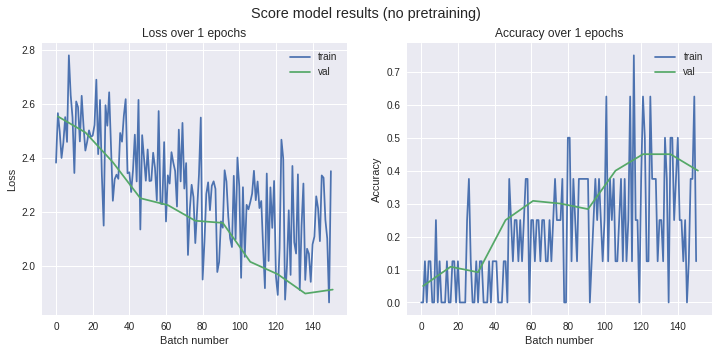

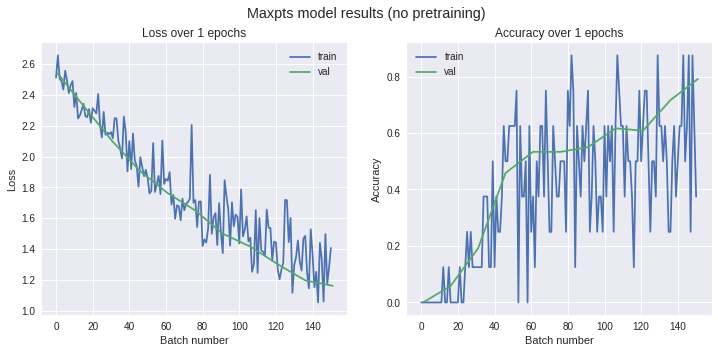

In [0]:
score_scope(H=64, W=128, batch_size=8, num_epochs=1, val_split=0.1, 
            pretrained_state_dict=None, val_frequency=15, best_score_acc=0.5,
           best_maxpts_acc=0.8)

  0%|          | 0/151 [00:00<?, ?it/s]


EPOCH 1/1



Validation 1/11: score loss 3.137, acc:0.342; maxpts loss 0.444, acc:0.875: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]
Validation 2/11: score loss 3.105, acc:0.325; maxpts loss 0.503, acc:0.817: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]
Validation 3/11: score loss 2.673, acc:0.375; maxpts loss 0.476, acc:0.850: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]
Score: loss 1.374, acc 0.625; Maxpts: loss 0.224, acc 0.875:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 4/11: score loss 2.465, acc:0.383; maxpts loss 0.397, acc:0.867: 100%|██████████| 15/15 [00:14<00:00,  1.07s/it]
Validation 5/11: score loss 1.998, acc:0.492; maxpts loss 0.362, acc:0.892: 100%|██████████| 15/15 [00:14<00:00,  1.01s/it]
Validation 6/11: score loss 1.834, acc:0.475; maxpts loss 0.350, acc:0.900

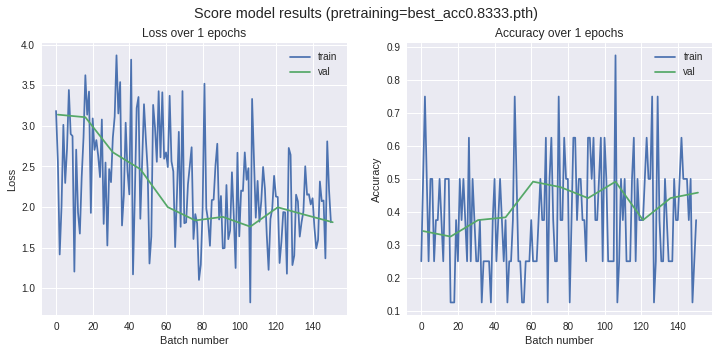

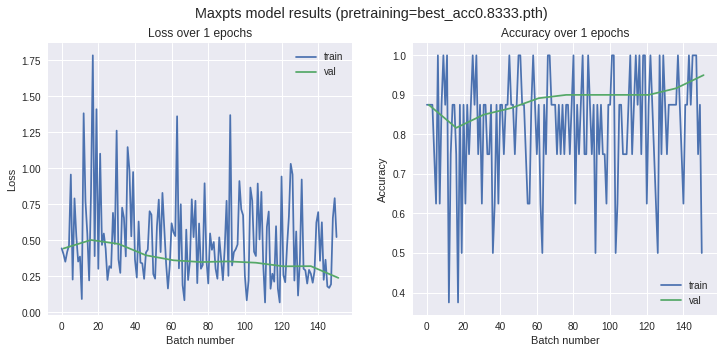

In [0]:
score_scope(H=64, W=128, batch_size=8, num_epochs=1, val_split=0.1, 
            pretrained_state_dict='best_acc0.8333.pth', val_frequency=15)

## Lots of epochs

Validation 1/3: score loss 2.915, acc 0.000; Maxpts: loss 1.698, acc 0.500:  13%|█▎        | 2/15 [00:02<00:14,  1.10s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 1/3: score loss 2.626, acc 0.125; maxpts loss 1.864, acc 0.417: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s] 
Validation 2/3: score loss 2.246, acc 0.133; maxpts loss 1.508, acc 0.567: 100%|██████████| 15/15 [00:15<00:00,  1.05it/s] 
Validation 3/3: score loss 1.932, acc 0.433; maxpts loss 1.154, acc 0.667: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s] 

Validation 1/3: score loss 1.925, acc 0.383; maxpts loss 1.059, acc 0.700: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s] 
Validation 2/3: score loss 1.773, acc 0.417; maxpts loss 1.044, acc 0.642: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s] 
Validation 3/3: score loss 1.481, acc 0.567; maxpts loss 0.

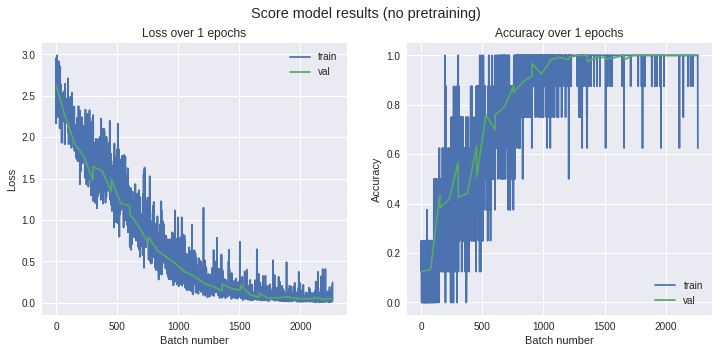

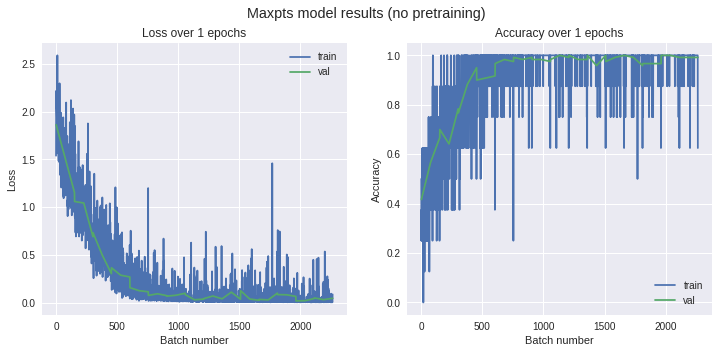

In [0]:
score_scope(H=64, W=128, batch_size=8, num_epochs=15, val_split=0.1, 
            pretrained_state_dict=None, val_frequency=75, best_score_acc=0.5,
            best_maxpts_acc=0.8)

# Statistics and figures

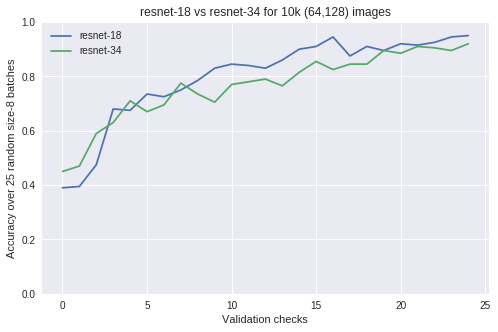

In [0]:
pylab.rcParams['figure.figsize'] = (8,5)
plt.plot([.39,.395,.475,.680,.675,.735,.725,.75,.785,.83,.845,.84,.83,.86,.9,
          .91,.945,.875,.91,.895,.92,.915,.925,.945,.95],label='resnet-18')

plt.plot([.45,.47,.59,.63,.71,.67,.695,.775,.735,.705,.77,.78,.79,.765,.815,
          .855,.825,.845,.845,.895,.885,.91,.905,.895,.92],label='resnet-34')
plt.ylim(0,1)
plt.xlabel('Validation checks')
plt.ylabel('Accuracy over 25 random size-8 batches')
plt.legend()
plt.title('resnet-18 vs resnet-34 for 10k (64,128) images')
plt.show()

[240.   211.92 108.    87.12  88.08  60.96  58.08  47.04  39.12  36.96
  34.08  36.    28.08  36.96  18.    29.04  12.    18.96  13.92  16.08
  11.04  23.04  18.    23.04  12.96  13.92  10.08  10.08  16.08  10.08
  14.88  16.08  12.96  10.08   7.92  12.    10.08   5.04  11.04   2.88
  11.04   6.     9.12  11.04  13.92  11.04   6.     2.88  11.04   6.96
   7.92   0.96  11.04]
53
[0.    0.117 0.55  0.637 0.633 0.746 0.758 0.804 0.837 0.846 0.858 0.85
 0.883 0.846 0.925 0.879 0.95  0.921 0.942 0.933 0.954 0.904 0.925 0.904
 0.946 0.942 0.958 0.958 0.933 0.958 0.938 0.933 0.946 0.958 0.967 0.95
 0.958 0.979 0.954 0.988 0.954 0.975 0.962 0.954 0.942 0.954 0.975 0.988
 0.954 0.971 0.967 0.996 0.954]
[0.961 0.958 0.953 0.956 0.965 0.968 0.972 0.97  0.972 0.972]
[0.966 0.964 0.96  0.963 0.963 0.963 0.963 0.963 0.968 0.97 ]


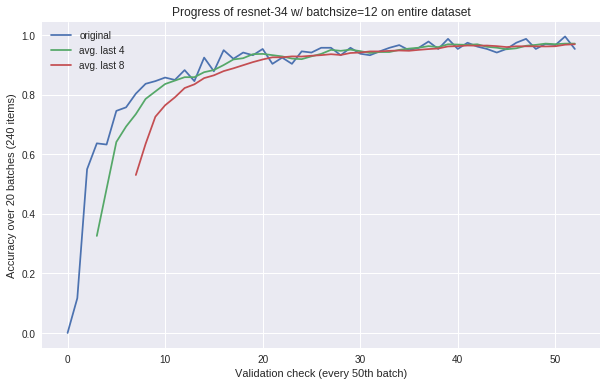

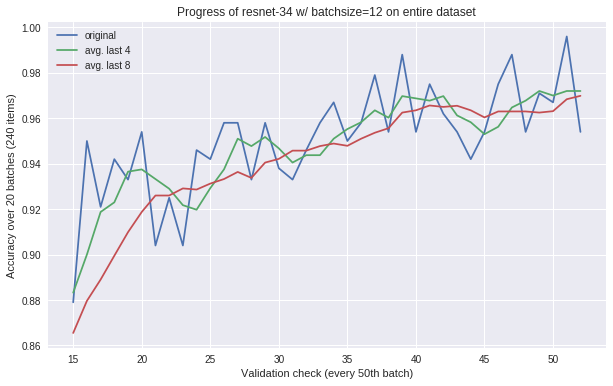

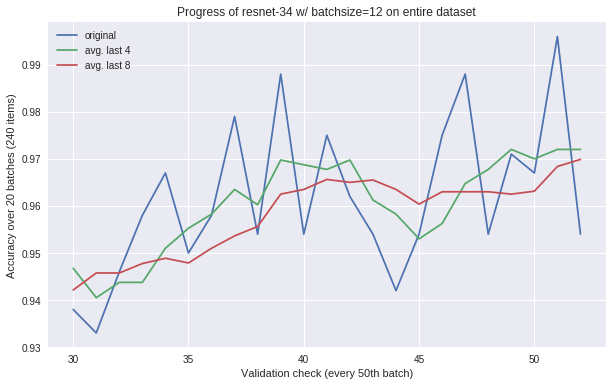

In [0]:
import numpy as np

import seaborn
from matplotlib import pyplot as plt
import pylab

accs = np.array([0.0,.117,.550,.637,.633,.746,.758,.804,.837,.846,
                .858,.850,.883,.846,.925,.879,.950,.921,.942,.933,
                .954,.904,.925,.904,.946,.942,.958,.958,.933,.958,
                .938,.933,.946,.958,.967,.950,.958,.979,.954,.988,
                .954,.975,.962,.954,.942,.954,.975,.988,.954,.971,
                .967,.996,.954])

number_wrong = 240*(1-accs)
print(number_wrong)
print(len(accs))

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

print(np.round(accs,3))
print(np.round(running_mean(accs,4)[-10:],3))
print(np.round(running_mean(accs,8)[-10:],3))
pylab.rcParams['figure.figsize'] = (10,6)
d = np.arange(len(accs))

for s in [0,15,30]:
    plt.plot(d[s:], accs[s:], label='original')
    if s > 0:
        plt.plot(d[s:], running_mean(accs,4)[s-3:], label='avg. last 4')
        plt.plot(d[s:], running_mean(accs,8)[s-7:], label='avg. last 8')
    else:
        plt.plot(d[s+3:], running_mean(accs,4)[s:], label='avg. last 4')
        plt.plot(d[s+7:], running_mean(accs,8)[s:], label='avg. last 8')
    plt.legend()
    plt.title('Progress of resnet-34 w/ batchsize=12 on entire dataset')
    plt.xlabel('Validation check (every 50th batch)')
    plt.ylabel('Accuracy over 20 batches (240 items)')
    plt.show()

In [0]:
# Distribution of how many points it's out of

# Scratch work for making ScoreLabeledDataset

In [0]:
dataset = Graded112Dataset()

n = len(dataset) 
print("len(dataset):", len(dataset))
num_to_label = 5000
inds = np.random.choice(n, num_to_label)
scored_files = dict()

len(dataset): 36766


In [0]:
grade_labeled = dict()
already_there = glob.glob(base_filename('Score Labeled/')+"/*.png")
print("\nStarted with", len(already_there), "in the folder\n")

loop = tqdm(total=1250, position=0, leave=True)

with open(base_filename('score_labels.csv'),'r') as f:
    reader = csv.reader(f)
    for (file, score, max_score) in reader:
        if file != "File stub" and score != -1:
            
            from_stub =  score_labeled_from_stub(file)         
            new_filename = base_filename(from_stub)
            
            if int(score) < 0:
                loop.set_description(from_stub+" not graded; ignore")
            
            elif new_filename in already_there:
                loop.set_description('Ya tiene '+from_stub)
                grade_labeled[from_stub] = (int(score), int(max_score))
                
            
            else:
                img = PIL.Image.open(base_filename(file))
                img.save(new_filename)
                loop.set_description(file.replace('Graded Pages/',''))
                grade_labeled[from_stub] = (int(score), int(max_score))
            loop.update(1)
            
print("\n\nNow we have", len(glob.glob(base_filename('Score Labeled/')+"/*.png")))
print("len(grade_labeled):", len(grade_labeled))

Ya tiene Score Labeled/F18_Exam2_Platt-Graded_page178.png:   3%|▎         | 38/1250 [00:00<00:06, 187.03it/s]     


Started with 1205 in the folder



Ya tiene Score Labeled/F17_Final_24Platt2_graded_page139.png:  98%|█████████▊| 1224/1250 [00:05<00:00, 207.17it/s]        



Now we have 1205
len(grade_labeled): 1205


# Output stuff for score labeling spreadsheet

In [0]:
import pylab
print(pylab.rcParams['figure.figsize'])
pylab.rcParams['figure.figsize'] = (9,3)

def display_img(img):
    img = img.narrow(1, 10, 110)
    #img.narrow(0, 75, 450)
    #img = img.narrow(2, 75, 400)
    img = img.permute(1,2,0)
    plt.imshow(img.detach())
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def display_images(start, stop, scored_files, dataset):
    
    with open(base_filename('score_labeling'+str(start)+'_'+str(stop)+'.csv'),'w') as f:
        writer = csv.writer(f)
        if start == 0:
            writer.writerow(['File stub', 'Score received', 'Out of'])
        for j in range(start, stop):
            i = inds[j]
            img, _, max_score = dataset[i]
            fname = short_filename(dataset.image_folder.imgs[i][0])
            print('\n({}/{}) {} ({} pts possible)'.format(j-start, stop-start,
                                                          fname, max_score))
            writer.writerow([fname, '', max_score])
            display_img(img)

            scored_files[dataset.image_folder.imgs[i][0]] = -1

[8.0, 5.5]


In [0]:
display_images(950, 1000, scored_files, dataset)

In [0]:
grade_labeled = dict()
already_there = glob.glob(base_filename('Score Labeled/')+"/*.png")
print("\nStarted with", len(already_there), "in the folder\n")

with open(base_filename('score_labels.csv'),'r') as f:
    reader = csv.reader(f)
    for (file, score, max_score) in reader:
        if file != "File stub" and int(score) >= 0:
            new_filename = base_filename(score_labeled_from_stub(file))
            grade_labeled[new_filename] = (int(score), int(max_score))
                
            
            
print("\n\nNow we have", len(glob.glob(base_filename('Score Labeled/')+"/*.png")))
print("len(grade_labeled):", len(grade_labeled))


Started with 1205 in the folder



Now we have 1205
len(grade_labeled): 1205
